In [ ]:
!nvidia-smi

Fri Jan 29 07:14:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --upgrade opencv-python
!pip install import_ipynb
!pip install latex2mathml
!pip install --upgrade matplotlib
!pip install flask

Requirement already up-to-date: opencv-python in /usr/local/lib/python3.6/dist-packages (4.5.1.48)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.3.4)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
print(cv2.__version__)
import numpy as np
import matplotlib
print(matplotlib.__version__)
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import import_ipynb

%cd /content/drive/My Drive/Final Project/Khang
from equations_solver import eq_solver
import os
from sympy.parsing.sympy_parser import parse_expr
import latex2mathml.converter
import urllib.request
from flask import Flask, flash, request, redirect, url_for, render_template, send_from_directory, send_file, Markup
from werkzeug.utils import secure_filename
import os
import time


4.5.1
3.3.4
/content/drive/My Drive/Final Project/Khang
importing Jupyter notebook from equations_solver.ipynb
['+2*a**2+4*b-6', '+a-b+5*c-5', '+b-2*c+1']


In [ ]:
class yolov4:
  def __init__(self,image, net, label):
    # self.weight_path = weight_path
    # self.config_path = config_path
    self.label = label
    self.image = image
    self.net = net

  def detection(self, confidence_threshold, NMS_threshold):
    h,w,_ = self.image.shape

    #net = cv2.dnn.readNet(self.weight_path, self.config_path)
    layer_names = self.net.getLayerNames()
    output_layers = [layer_names[i[0] -1] for i in self.net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(self.image, 1/255., (416,416), swapRB = True, crop = False)
    
    self.net.setInput(blob)
    layer_outputs = self.net.forward(output_layers)

    boxes = []
    confidences = []
    class_ids = []
    for output in layer_outputs :
      for detection in output :
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        
      
        if confidence > confidence_threshold :

          center_x, center_y, width, height = list(map(int, detection[0:4] * [w,h,w,h]))

          top_left_x = int(center_x - (width/2) )
          top_left_y = int(center_y - (height/2) )

          boxes.append([top_left_x, top_left_y, width, height])
          confidences.append(float(confidence))
          class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, NMS_threshold)
    self.num_obj = len(indexes)

    list_coor = []
    crop_scale = 0.05
    if len(indexes) > 0:
      for i in indexes.flatten():
        x, y, w, h = boxes[i]
        x = abs(int(x - crop_scale*w))
        y = abs(int(y - crop_scale*h))
        w = abs(int((1 + 2*crop_scale)*w))
        h = abs(int((1 + 2*crop_scale)*h))

        list_coor.append((x,y,w,h))
      
    list_coor = sorted(list_coor, key = lambda x : x[0])

    return [[x,y,w,h] for x,y,w,h in list_coor]  

  def __str__(self):
    return "Number of object detected: {}".format(self.num_obj)

  def num(self):
    return self.num_obj

In [ ]:
%cd /content/drive/My Drive/Final Project/Khang/darknet
!make
!sudo chmod +x darknet


/content/drive/My Drive/Final Project/Khang/darknet
chmod +x *.sh


In [ ]:
def show_image(image_list):
  for image in image_list:
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.axis('off')

In [ ]:
def ocr(list_image) :
  eq_str =""
  for image in list_image :
    preprocess_image = preprocessing_image(image)
    y_predict = model.predict(preprocess_image.reshape(1,28,28,1))
    text_predict = names[np.argmax(y_predict)]
    print(text_predict, np.max(y_predict))
    if np.max(y_predict) >= 0.5 :
      eq_str += text_predict
  return eq_str

In [ ]:
def preprocessing_image(image):
    """
    preprocess character's images
    """
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_blur = cv2.medianBlur(image_gray, 3)
    ret, thresh = cv2.threshold(image_blur, 120, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
    image_bw = cv2.bitwise_not(thresh)

    #Padding
    h, w = image_gray.shape
    pad_size = int(abs(h-w)/2)
    pad_extra = abs(h-w)%2
    image_padding = np.array([])
    if h > w:
      image_padding = cv2.copyMakeBorder(image_bw, 0,0, pad_size + pad_extra, pad_size, cv2.BORDER_CONSTANT, value = [0,0,0])
      image_padding = cv2.copyMakeBorder(image_padding, 5,5,5,5, cv2.BORDER_CONSTANT, value = [0,0,0])
    elif w > h :
      image_padding = cv2.copyMakeBorder(image_bw,pad_size + pad_extra, pad_size,0,0, cv2.BORDER_CONSTANT, value = [0,0,0])
      image_padding = cv2.copyMakeBorder(image_padding, 5,5,5,5, cv2.BORDER_CONSTANT, value = [0,0,0])
    else :
      image_padding = image_bw
    
    #Resize 28x28
    image_resized = cv2.resize(image_padding, (28,28))

    #Dilate
    kernel_dilate = np.array((3,3), np.uint8)
    image_dilate = cv2.dilate(image_resized, kernel_dilate)

    show_image([image_dilate])
    plt.show()

    #Expand dims
    image_result = np.expand_dims(image_dilate, 0)
    return image_result

In [ ]:
def text_skew(image, coor, check) :
  print(coor)
  
  np_coor = np.array(coor)
  x_new = np.min(np_coor[:,0])
  y_new = np.min(np_coor[:,1])
  w_new = np.max(np.array([x + w for x,y,w,h in coor])) - x_new
  h_new = np.max(np_coor[:,1]) + np_coor[np.argmax(np_coor[:,1])][3] - np.min(np_coor[:,1])

 #Crop soe
  soe_cropped = image[y_new : y_new + h_new, x_new : x_new + w_new]
  # If check == true thì chỉ trả về ảnh đc crop
  if check == True :
    return soe_cropped
  #if check == False thì sẽ trả về ảnh gốc đã được xoay
  else :
    gray = cv2.cvtColor(soe_cropped, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    image_black = np.zeros((image.shape[0], image.shape[1]))
    image_black[y_new : y_new + h_new, x_new : x_new + w_new] = thresh
    
    coords = np.column_stack(np.where(image_black > 0))
    angle = cv2.minAreaRect(coords)[-1]
    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
      angle = -(90 + angle)
    # otherwise, just take the inverse of the angle to make
    # it positive
    else:
      angle = -angle
    print(angle)
    # if abs(angle) < 10 :
    #   return image
    
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
      flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated

In [ ]:
names = ['+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'a', 'b', 'c', 'd', 'x', 'y', 'z']

In [ ]:
equation_weight = "/content/drive/My Drive/Final Project/Khang/weights/yolov4_training_2000_eq.weights"
char_weight =  "/content/drive/My Drive/Final Project/Khang/weights/yolov4_training_2000_char.weights"
config_path = "/content/drive/My Drive/Final Project/Khang/darknet/cfg/yolov4_training.cfg"
ocr_path = "/content/drive/My Drive/Final Project/Khang/weights/model_ocr.h5"

In [ ]:
def eq_4_display(list_eq):
  list_4_display =[]
  for eq in list_eq :
    string = ""
    for i,char in enumerate(eq):
      if char in ["+", "="]:
        string += " " + char + " "
      elif char == "-":
        if i == 0 or string[len(string)-2:len(string)] == "= ":
          string += char
        else :
          string += " " + char + " "
      elif char.isnumeric() :
        if i == 0 :
          string += char
        elif string[-1].isalpha():
          string += "^" + char
        else :
          string += char
      else :
        string += char
      #print(string)
    mathml_output = latex2mathml.converter.convert(string)
    list_4_display.append(mathml_output)
  return list_4_display

In [ ]:
eq_4_display(['x+3y=11', '4x-7y=6'])

['<math display="inline" xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>x</mi><mo>&#x0002B;</mo><mn>3</mn><mi>y</mi><mo>&#x0003D;</mo><mn>11</mn></mrow></math>',
 '<math display="inline" xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mn>4</mn><mi>x</mi><mo>&#x02212;</mo><mn>7</mn><mi>y</mi><mo>&#x0003D;</mo><mn>6</mn></mrow></math>']

In [ ]:
#image_path = "/content/drive/My Drive/Final Project/Khang/image_test/9.jpg"
model = load_model(ocr_path)
yolov4_char = cv2.dnn.readNet(char_weight, config_path)
yolov4_eq = cv2.dnn.readNet(equation_weight, config_path) 

def soe_solver(image_path):
    # đọc ảnh 
  img_test = cv2.imread(image_path)
    #1  detect pt trong ảnh
  equation_detection = yolov4(img_test,yolov4_eq, "eq")
  equation_coor = equation_detection.detection(0.5, 0.4) # get coordinate of all eqs
  print(equation_coor)
 
  #2 rotate img base on above coordinates
  image_skew = text_skew(img_test, equation_coor, False)
  
  #3 Detect phương trình again
  equation_detection_1 = yolov4(image_skew,yolov4_eq , "eq")
  equation_coor_1 = equation_detection_1.detection(0.5, 0.4) # 1-> new
  print(equation_detection_1)

  #Sắp xếp theo chiều từ trên xuống theo truc y
  equation_coor_1 = sorted(equation_coor_1, key = lambda x:x[1])

  
  #List equation images
  equation_image = [image_skew[y:(y + h), x:(x + w + 5)] for x, y, w, h in equation_coor_1]
  show_image(equation_image)

  list_text_equation = []
  # 
  for num, eq in enumerate(equation_image) :
    print(eq.shape)
    #5  detect characters in each equations images
    char_detection = yolov4(eq,yolov4_char , "char")
    char_coor = char_detection.detection(0.5, 0.3)

    #List character images
    char_image = [eq[y:y+h, x:x+w] for x,y,w,h in char_coor]
    
    text = ocr(char_image) #6 classify character images
    list_text_equation.append(text)
    print(text)
    print("...................................")
    pass

  #  
  print(list_text_equation)
  result = eq_solver(list_text_equation) #7 solve those equations
  print(result)

  # crop again for displaying on web
  eqs_cropped = text_skew(image_skew, equation_coor_1, True)
  
  return eqs_cropped , [latex2mathml.converter.convert(r) for r in result] , eq_4_display(list_text_equation)

In [ ]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))


https://t88o8vpwxz-496ff2e9c6d22116-5000-colab.googleusercontent.com/


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [29/Jan/2021 05:15:27] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2021 05:15:30] "GET /favicon.ico HTTP/1.1" 404 -


<FileStorage: 'test11.jpg' ('image/jpeg')>
[[75, 633, 432, 107], [81, 742, 303, 112]]
[[75, 633, 432, 107], [81, 742, 303, 112]]
-8.130102157592773
Number of object detected: 2
(124, 471, 3)


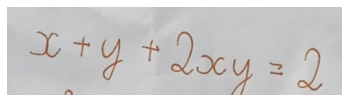

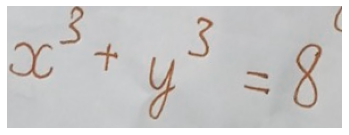

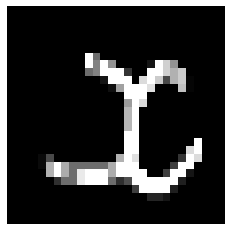

x 0.99999785


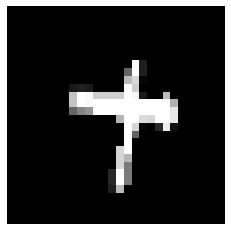

+ 0.99740237


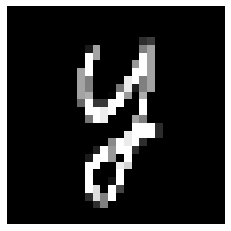

y 0.99989593


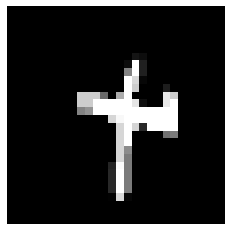

+ 0.99740237


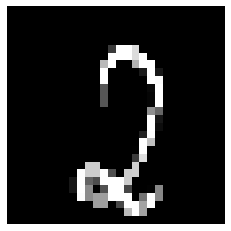

2 0.9994978


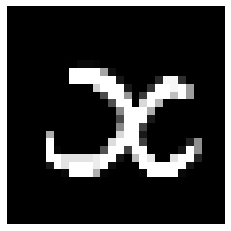

x 0.9999999


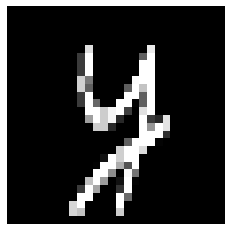

y 0.99939156


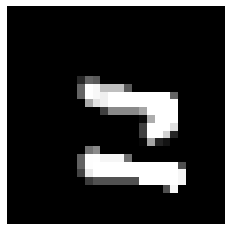

= 0.99657214


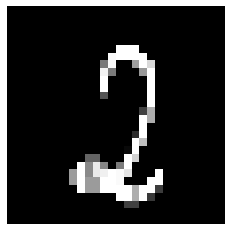

2 0.99939144
x+y+2xy=2
...................................
(107, 295, 3)


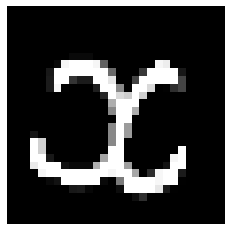

x 0.9999988


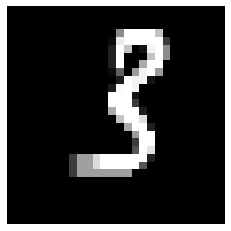

3 1.0


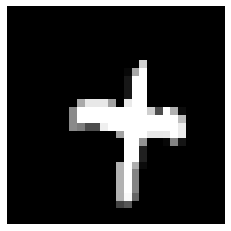

+ 0.99740237


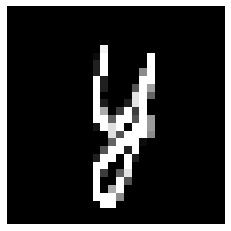

y 0.9996494


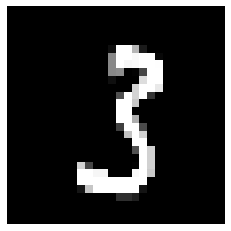

3 1.0


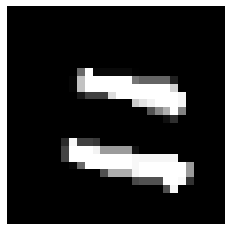

= 0.99999547


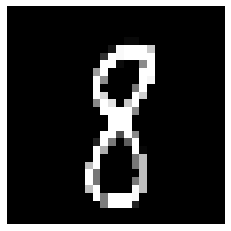

8 1.0


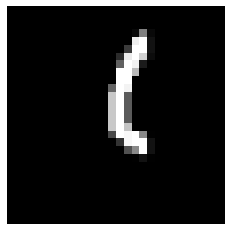

1 0.21216533
x3+y3=8
...................................
['x+y+2xy=2', 'x3+y3=8']
['+x+y+2*x*y-2', '+x**3+y**3-8']
['( x = 0 , y = 2 )', '( x = 2 , y = 0 )', '( x = - \\frac{7}{8} - \\frac{\\sqrt{15} i}{8} + \\frac{1}{8} \\sqrt{-86 + 6 \\sqrt{15} i} , y = - \\frac{7}{8} - \\sqrt{- \\frac{43}{32} + \\frac{3 i}{32} \\sqrt{15}} - \\frac{\\sqrt{15} i}{8} )', '( x = - \\frac{7}{8} + \\frac{\\sqrt{15} i}{8} - \\frac{1}{8} \\sqrt{-86 - 6 \\sqrt{15} i} , y = - \\frac{7}{8} + \\sqrt{- \\frac{43}{32} - \\frac{3 i}{32} \\sqrt{15}} + \\frac{\\sqrt{15} i}{8} )', '( x = - \\frac{7}{8} + \\frac{1}{8} \\sqrt{-86 - 6 \\sqrt{15} i} + \\frac{\\sqrt{15} i}{8} , y = - \\frac{7}{8} + \\frac{\\sqrt{15} i}{8} - \\sqrt{- \\frac{43}{32} - \\frac{3 i}{32} \\sqrt{15}} )', '( x = - \\frac{7}{8} - \\frac{1}{8} \\sqrt{-86 + 6 \\sqrt{15} i} - \\frac{\\sqrt{15} i}{8} , y = - \\frac{7}{8} - \\frac{\\sqrt{15} i}{8} + \\sqrt{- \\frac{43}{32} + \\frac{3 i}{32} \\sqrt{15}} )']
[[46, 620, 466, 124], [71, 736, 290, 107]]


127.0.0.1 - - [29/Jan/2021 05:19:46] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2021 05:19:47] "GET /images/original_test11.jpg HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2021 05:19:47] "GET /images/cropped_test11.jpg HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2021 05:19:49] "GET /favicon.ico HTTP/1.1" 404 -


<FileStorage: 'fe1bfdb5f8db088551ca.jpg' ('image/jpeg')>
[[69, 649, 641, 138], [80, 757, 629, 158]]
[[69, 649, 641, 138], [80, 757, 629, 158]]
-90.0
Number of object detected: 5
(110, 172, 3)


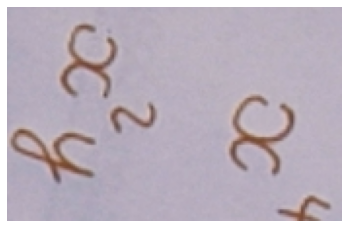

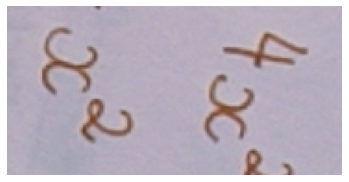

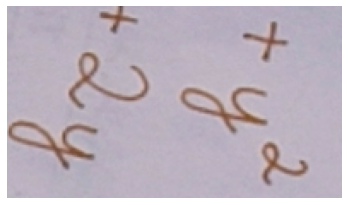

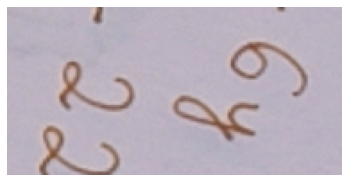

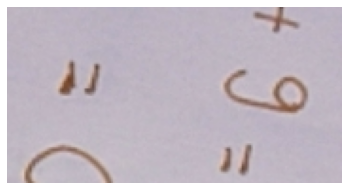

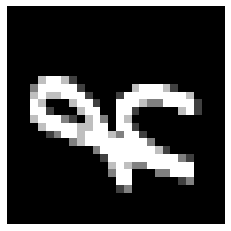

4 0.83622295


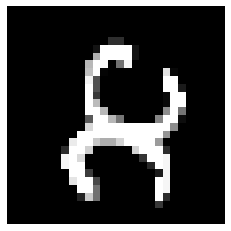

8 0.99999535


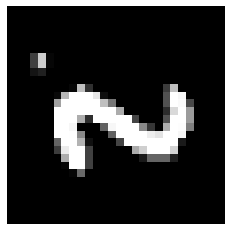

a 0.949731


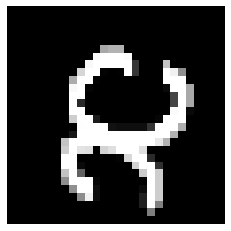

8 0.9999896


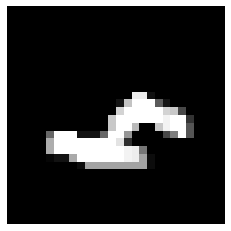

b 0.9683565
48a8b
...................................
(91, 181, 3)


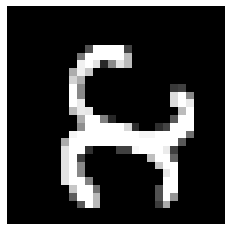

8 0.99939823


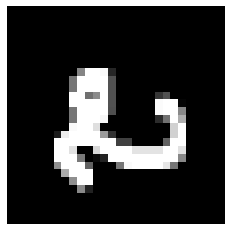

8 0.9026435


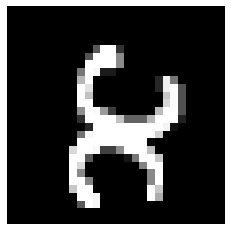

8 0.9999976


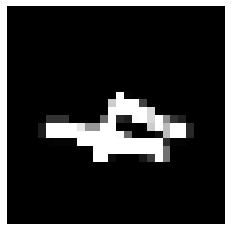

6 0.5031191


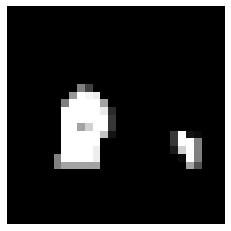

2 0.63070893
88862
...................................
(112, 196, 3)


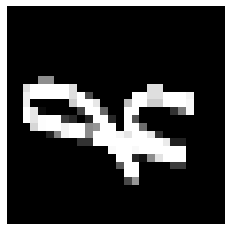

x 0.42675626


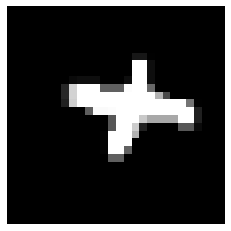

+ 0.99740237


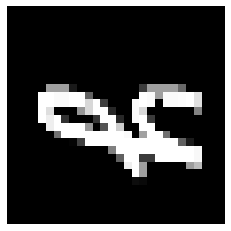

4 0.3756532


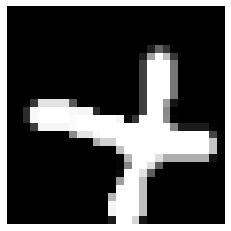

+ 0.99740237


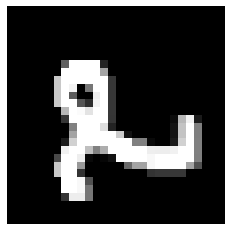

8 0.90496105
++8
...................................
(94, 187, 3)


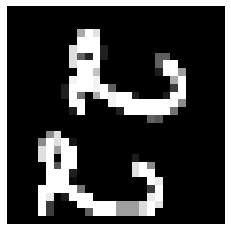

8 0.916637


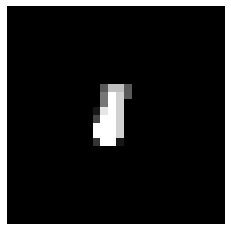

b 0.9996141


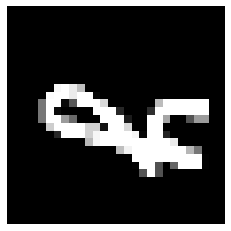

4 0.4780684
8b
...................................
(93, 177, 3)


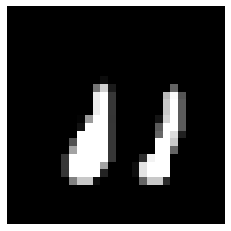

- 0.8395226


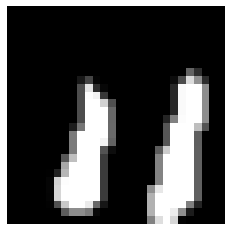

- 0.3504458


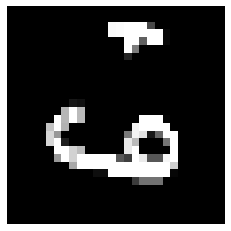

5 0.9322164


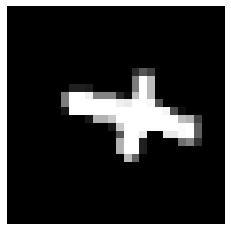

[2021-01-29 05:20:28,154] ERROR in app: Exception on / [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.6/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-17-d686b8c16bc2>", line 32, in upload_image
    soe_image, result, list_text_equation = so

+ 0.9779935
-5+
...................................
['48a8b', '88862', '++8', '8b', '-5+']
['+48*a**8*b', '+88862', '++8', '+8*b', '-5+']


127.0.0.1 - - [29/Jan/2021 05:20:49] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2021 05:20:49] "GET /favicon.ico HTTP/1.1" 404 -


<FileStorage: 'bf5d479768f998a7c1e8.jpg' ('image/jpeg')>
[[59, 225, 1103, 156], [90, 100, 773, 143]]
[[59, 225, 1103, 156], [90, 100, 773, 143]]
-0.9166542887687683
Number of object detected: 2
(154, 770, 3)


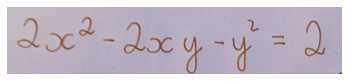

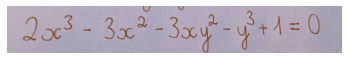

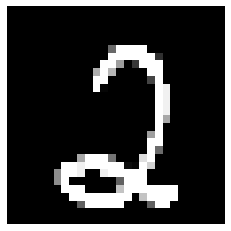

2 0.999668


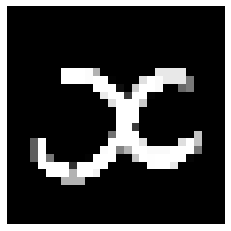

x 0.9999999


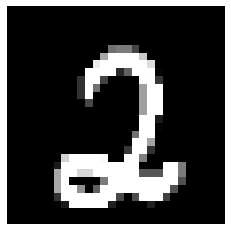

2 0.9996866


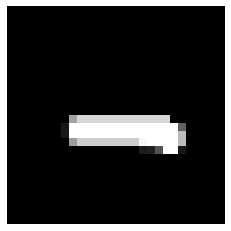

- 0.99676406


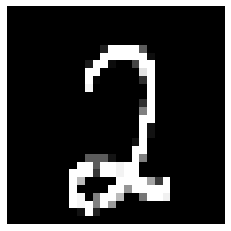

2 0.9999043


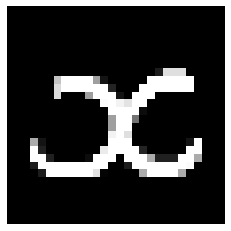

x 0.99999976


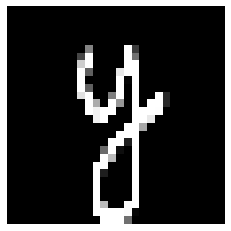

y 0.9992337


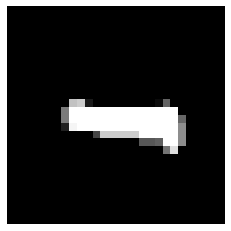

- 0.9979425


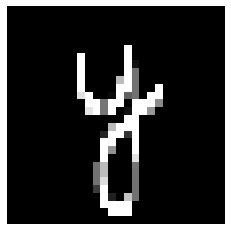

y 0.9994867


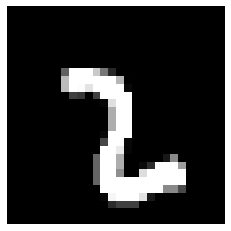

2 0.99530715


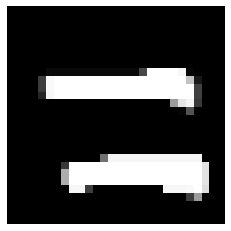

= 0.9999989


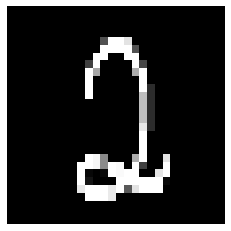

2 0.9996006
2x2-2xy-y2=2
...................................
(156, 1122, 3)


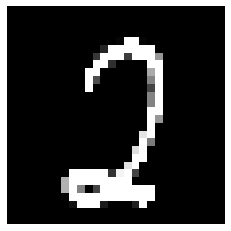

2 0.999882


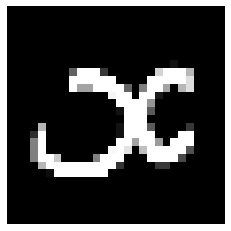

x 0.99999857


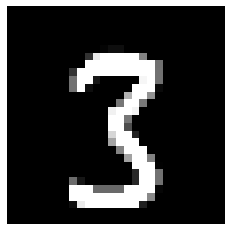

3 1.0


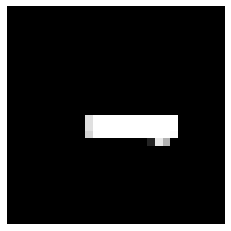

- 0.9958246


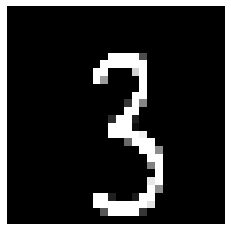

3 1.0


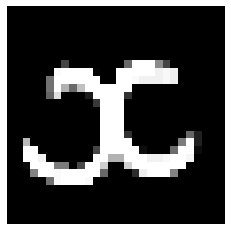

x 0.99999774


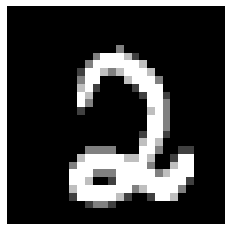

2 0.99966645


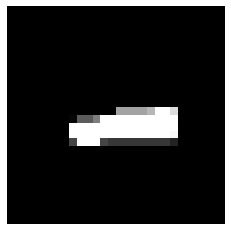

- 0.99766386


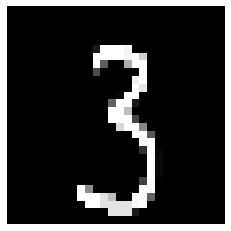

3 1.0


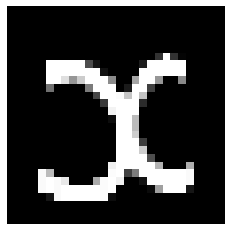

x 0.99999964


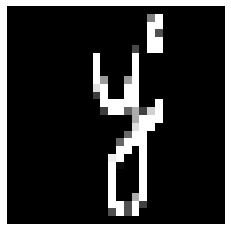

y 0.9987295


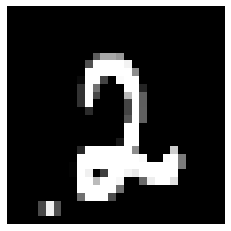

2 0.99911827


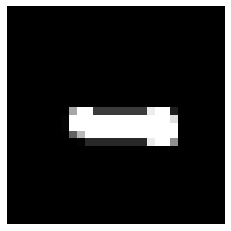

- 0.997546


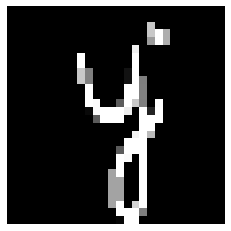

y 0.9993104


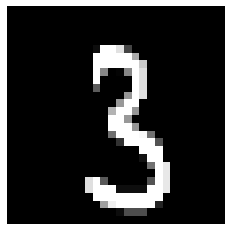

3 1.0


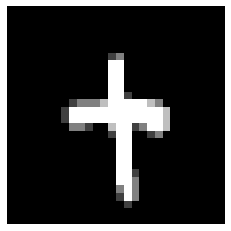

+ 0.99740237


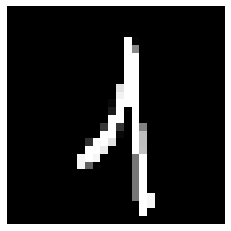

1 0.9999733


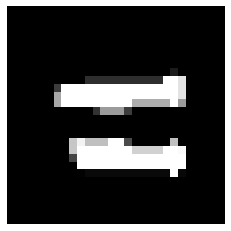

= 0.99999905


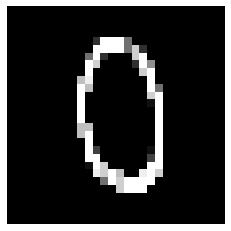

0 0.99998665
2x3-3x2-3xy2-y3+1=0
...................................
['2x2-2xy-y2=2', '2x3-3x2-3xy2-y3+1=0']
['+2*x**2-2*x*y-y**2-2', '+2*x**3-3*x**2-3*x*y**2-y**3+1-0']
['( x = -1 , y = 2 )', '( x = 1 , y = 0 )']
[[97, 92, 765, 154], [54, 226, 1117, 156]]


127.0.0.1 - - [29/Jan/2021 05:21:18] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2021 05:21:19] "GET /images/original_bf5d479768f998a7c1e8.jpg HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2021 05:21:19] "GET /images/cropped_bf5d479768f998a7c1e8.jpg HTTP/1.1" 200 -
127.0.0.1 - - [29/Jan/2021 05:21:21] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
#8
app  = Flask(__name__, template_folder= "/content/drive/My Drive/Final Project/Khang/templates")
UPLOAD_FOLDER = '/content/drive/My Drive/Final Project/Khang/static/uploads'
app.secret_key = "secret key"
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
app.config['MAX_CONTENT_LENGTH'] = 16 * 1024 * 1024

ALLOWED_EXTENSIONS = set(['png', 'jpg', 'jpeg', 'gif'])

def allowed_file(filename):
	return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

@app.route('/')
def home():
  return render_template("upload.html")

@app.route('/images/<filename>')
def images(filename):
  image_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
  return send_file(image_path)

@app.route('/', methods=['GET','POST'])
def upload_image():
  if request.method == 'POST' :
    file = request.files['file']
    print(file)
    if file and allowed_file(file.filename):
      filename = secure_filename(file.filename)
      full_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
      file.save(full_path)
      #Predict
      soe_image, result, list_text_equation = soe_solver(full_path)
      #Image cropped
      cv2.imwrite(app.config['UPLOAD_FOLDER']+ '/cropped_'+filename, soe_image)
      soe_image = cv2.copyMakeBorder(soe_image, 0,0,10,0, cv2.BORDER_CONSTANT, value = [0,0,0])
      image_cropped_url = url_for('images', filename ='cropped_' +filename)
      #Original image
      original_image = cv2.imread(full_path)
      original_image = cv2.copyMakeBorder(original_image, 0,0,0,10, cv2.BORDER_CONSTANT, value =[0,0,0])
      cv2.imwrite(app.config['UPLOAD_FOLDER']+ '/original_'+filename, original_image)
      original_image_url = url_for('images', filename ='original_' +filename)

      return render_template("upload.html", original_image = original_image_url, cropped_image = image_cropped_url, result = result, text = list_text_equation )
  else :
    return redirect("/")

if __name__ == "__main__" :
  app.run()


